This notebook analyses the accuracy of derivative approximations using finite difference schemes and utilizes these to model the advection and diffusion equation. It compares these schemes to the newer and more sophisticated WENO schemes, particularly analysing the performance of the schemes around shocks or discontinuities

In [1]:
using Plots
using LinearAlgebra
using BenchmarkTools

Useful functions for determining the error (defined here as average deviation from analytic solution) and computing the next step of a PDE given the corresponding matrix 

In [2]:
error(numerical, analytical) = mean(abs.(analytical - numerical)) 
error_without_endpoints(numerical, analytical) = mean(abs.(analytical[3:end-3] - numerical[3:end-3])) 

function next_step_matrix!(c, matrix)
    c .= matrix*c
end

next_step_matrix! (generic function with 1 method)

Implementation of the forward, backward and centred difference derivative approximations

In [3]:
function forward_difference(f, dx)
    l = length(f)
    fprime = zeros(l)
    for i in 1:(l-1)
        fprime[i] = (f[i+1]-f[i])/dx
    end
    fprime[l] = (f[l]-f[l-1])/dx
    return fprime
end

function backward_difference(f, dx)
    l = length(f)
    fprime = zeros(l)
    for i in 2:l
        fprime[i] = (f[i]-f[i-1])/dx
    end
    fprime[1] = (f[2]-f[1])/dx
    return fprime
end

function centred_difference(f, dx)
    l = length(f)
    fprime = zeros(l)
    for i in 2:(l-1)
        fprime[i] = (f[i+1]-f[i-1])/(2*dx)
    end
    fprime[1] = (f[2]-f[1])/dx
    fprime[l] = (f[l]-f[l-1])/dx
    return fprime
end

centred_difference (generic function with 1 method)

An example of the comparison between the forward and centred difference derivative approximations compared to the analytic derivaitve 

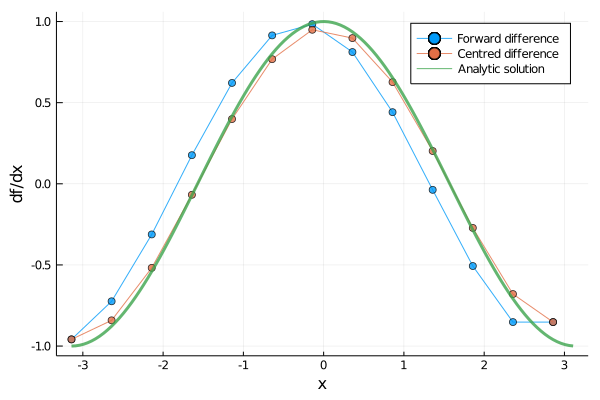

In [4]:
L = pi
dx = 0.5
x = collect(-L:dx:L)
f = sin.(x)
forward_d = forward_difference(f, dx)
centred_d = centred_difference(f, dx)
plot(x,[forward_d, centred_d], 
    label = ["Forward difference" "Centred difference"],
    linestyle=:solid, markershape = :circle, alpha=0.8, 
    xlabel = "x", 
    ylabel = "df/dx")
dx = 0.05
x = collect(-L:dx:L)
analytic = cos.(x)
plot!(x, analytic, 
    label = "Analytic solution", lw=3, alpha=0.8)

Comparing the average deviation from the analytic solution of the forward and centred difference schemes for a varying spatial discretisation. The results of this simulation are plotted on a log-log plot below and we can see that the forward difference scheme scales with δx whilst the centred difference scheme scales with δx²

In [24]:
function error_varying_delta(L, deltas)
    fs = zeros(0)
    cs = zeros(0)
    for delta in deltas
        x = collect(-L:delta:L)
        f = sin.(x)
        analytic = cos.(x)
        forward_d = forward_difference(f, delta)
        centred_d = centred_difference(f, delta) 
        f_error = error_without_endpoints(analytic, forward_d)
        append!(fs, f_error)
        c_error = error_without_endpoints(analytic, centred_d)
        append!(cs, c_error)
    end
    return fs, cs
end

error_varying_delta (generic function with 1 method)

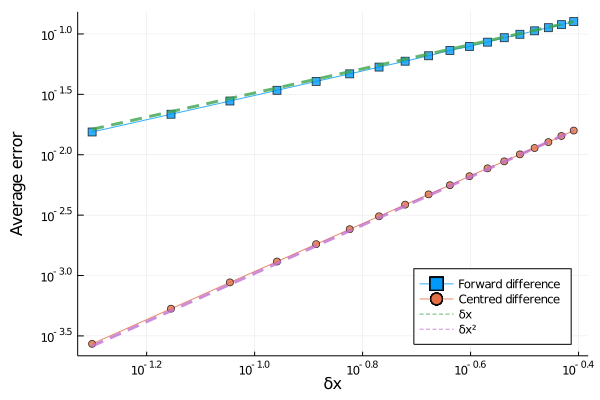

In [25]:
deltas = range(0.05, stop = 0.4, step = 0.02)
fd_error, cd_error = error_varying_delta(10, deltas)
fd_scaling = fd_error[end]*(deltas / deltas[end])
cd_scaling = cd_error[end]*(deltas / deltas[end]).^2

plot(deltas, [fd_error, cd_error, fd_scaling, cd_scaling,], 
    label = ["Forward difference" "Centred difference" "δx" "δx²"], legend=:bottomright, 
    xlabel = "δx", ylabel = "Average error", xaxis= :log, yaxis= :log, 
    m =[:rect :circle :none :none], linestyle=[:solid :solid :dash :dash], lw=[1 1 3 3], alpha=0.8)

## Modelling the Diffusion Equation

The matrix implemtation of a variety of schemes to model the diffusion equation

In [7]:
function ftcs_matrix(n, dx, dt, k)
    r = k*dt/dx^2
    d = (1-2*r)*ones(n)
    dl = r*ones(n-1)
    return Tridiagonal(dl, d, dl)
end

function btcs_matrix(n, dx, dt, k)
    r = k*dt/dx^2
    d = (1+2*r)*ones(n)
    dl = -r*ones(n-1)
    return inv(Tridiagonal(dl, d, dl))
end

# Crank Nicolson
function cn_matrix(n, dx, dt, k)
    r = k*dt/dx^2
    d = (2+2*r)*ones(n)
    dl = -r*ones(n-1)
    A = inv(Tridiagonal(dl, d, dl))
    d2 = (2-2*r)*ones(n)
    dl2 = r*ones(n-1)
    B = Tridiagonal(dl2, d2, dl2)
    return A*B
end

cn_matrix (generic function with 1 method)

Setting initial conditions (of a Gaussian) and parameters

In [8]:
function set_inital_conditions_diffusion(L, n, σ², dt, t, κ)
    dx = 2*L/(n-1)
    x = collect(-L:dx:L)
    time_steps = t/dt
    ftcs = ftcs_matrix(n, dx, dt, κ)
    btcs = btcs_matrix(n, dx, dt, κ)
    cn = cn_matrix(n, dx, dt, κ)
    c = @. exp(-x^2/(2*σ²))
    x0 = collect(-L:L/250:L)
    c0 = @. exp(-x0^2/(2*σ²))
    return dx, x, c, c0, x0, ftcs, btcs, cn, time_steps
end
analytic_cts(x, t, κ, σ²) = @. (1+2*κ*t/σ²)^-0.5*exp(-x^2/(2*σ²+4*κ*t))

analytic_cts (generic function with 1 method)

In [9]:
L = 1
n = 201
dt = 0.0005
σ² = 0.005
κ = 0.3
t = 0.02
dx, x, c, c0, x0, ftcs, btcs, cn, time_steps = set_inital_conditions_diffusion(L, n, σ², dt, t, κ);

Modelling the diffusion equation with the FTCS scheme, the numerical instability is due to the value of dt being too large.

┌ Info: Saved animation to 
│   fn = C:\Users\User\OneDrive - Australian National University\Documents\2020\ASC\Edited\analytic_diffusion.gif
└ @ Plots C:\Users\User\.julia\packages\Plots\XbAWb\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\User\\OneDrive - Australian National University\\Documents\\2020\\ASC\\Edited\\analytic_diffusion.gif")
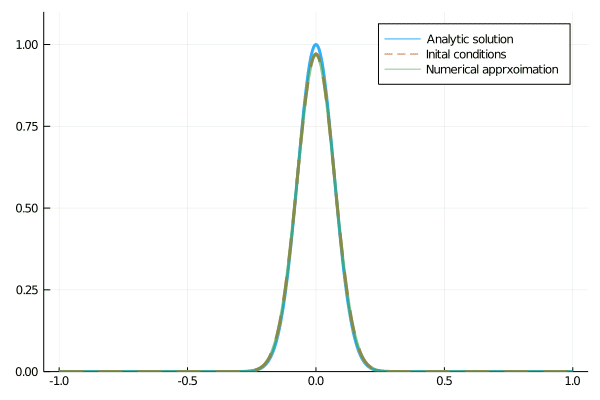

In [10]:
# Decrease dt to maintain stability
c_ftcs = zeros(n)
c_ftcs .= c
anim = @animate for i in 1:time_steps
    ana = analytic_cts(x0, dt*i, κ, σ²)
    plot(x0, [c0, ana], label = ["Analytic solution" "Inital conditions"], lw=3, linestyle=[:solid :dash], alpha = [0.8 1])
    next_step_matrix!(c_ftcs, ftcs)
    plot!(x, c_ftcs, ylims=(0, 1.1), label = "Numerical apprxoimation", lw=3, linestyle=:solid, alpha = 0.6)
end

gif(anim, "analytic_diffusion.gif", fps=10)

Modelling the diffusion equation with the BTCS scheme. No numerical instability

┌ Info: Saved animation to 
│   fn = C:\Users\User\OneDrive - Australian National University\Documents\2020\ASC\Edited\analytic_diffusion.gif
└ @ Plots C:\Users\User\.julia\packages\Plots\XbAWb\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\User\\OneDrive - Australian National University\\Documents\\2020\\ASC\\Edited\\analytic_diffusion.gif")
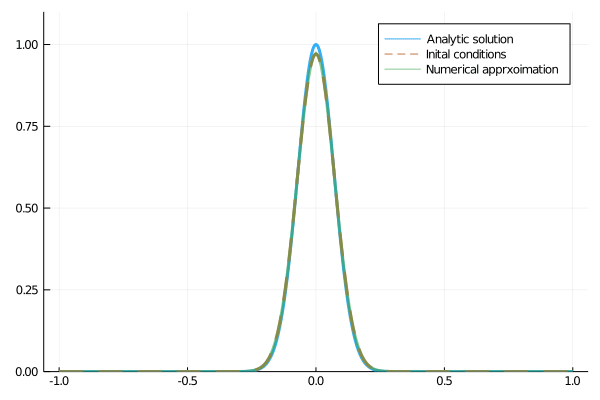

In [11]:
c_btcs = zeros(n)
c_btcs .= c
anim = @animate for i in 1:time_steps
    ana = analytic_cts(x0, dt*i, κ, σ²)
    plot(x0, [c0, ana], label = ["Analytic solution" "Inital conditions"], lw=3, linestyle=[:solid :dash], alpha = [0.8 1])
    next_step_matrix!(c_btcs, btcs)
    plot!(x, c_btcs, ylims=(0, 1.1), label = "Numerical apprxoimation", lw=3, linestyle=:solid, alpha = 0.6)
end

gif(anim, "analytic_diffusion.gif", fps=10)

Modelling the diffusion equation with the crank-nicolson scheme. No numerical instability

┌ Info: Saved animation to 
│   fn = C:\Users\User\OneDrive - Australian National University\Documents\2020\ASC\Edited\analytic_diffusion.gif
└ @ Plots C:\Users\User\.julia\packages\Plots\XbAWb\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\User\\OneDrive - Australian National University\\Documents\\2020\\ASC\\Edited\\analytic_diffusion.gif")
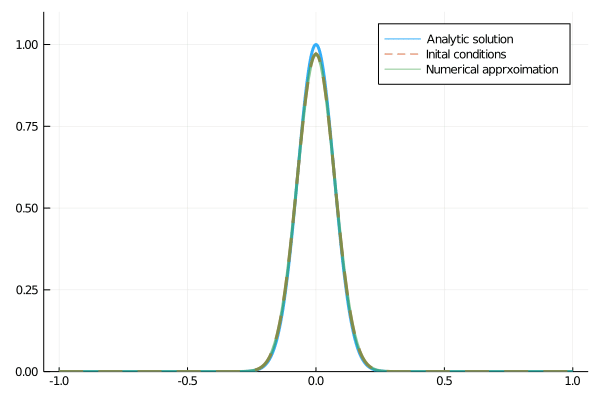

In [12]:
c_cn = zeros(n)
c_cn .= c
anim = @animate for i in 1:time_steps
    ana = analytic_cts(x0, dt*i, κ, σ²)
    plot(x0, [c0, ana], label = ["Analytic solution" "Inital conditions"], lw=3, linestyle=[:solid :dash], alpha = [0.8 1])
    next_step_matrix!(c_cn, cn)
    plot!(x, c_cn, ylims=(0, 1.1), label = "Numerical apprxoimation", lw=3, linestyle=:solid, alpha = 0.6)
end

gif(anim, "analytic_diffusion.gif", fps=10)

## The Advection Equation

Setting initial conditions (either smooth of discontinuous, determined by the value of cts) and parameters

In [13]:
function set_initial_conditions_advection(n, L, U, distance, CFL, cts, σ²)
    dx = 2*L/(n-1)
    dt = CFL*dx/U
    x = collect(-L:dx:L)
    x0 = collect(-L:L/250:L)
    if cts
        c0 = @. exp(-(x0+0.5)^2/(2*σ²))
        c = @. exp(-(x+0.5)^2/(2*σ²))
    else
        c0 = zeros(501)
        c0[abs.(x0.+0.5) .<= 0.25] .= 1
        c = zeros(n)
        c[abs.(x.+0.5) .<= 0.25] .= 1
    end
    ftbs = ftbs_matrix(n, dx, dt, U)
    time_steps = distance / dt
    return dx, dt, x, x0, c, c0, ftbs, time_steps
end

set_initial_conditions_advection (generic function with 1 method)

Continuous and discontinuous analytic solutions 

In [14]:
c_analytic(x, distance, σ²) = @. exp(-(x+0.5-distance)^2/(2*σ²))
function c_analytic(x, distance)
    c_ana = zeros(length(x))
    c_ana[abs.(x.+0.5.-distance) .<= 0.25] .= 1
    return c_ana
end

c_analytic (generic function with 2 methods)

Continuous and discontinuous analytic solutions 

In [15]:
function ftbs_matrix(n, dx, dt, U)
    r = U*dt/dx
    d = (1-r)*ones(n)
    dl = r*ones(n-1)
    du = zeros(n-1)
    return Tridiagonal(dl, d, du)
end

function ctcs_matrix(n, dx, dt, U)
    r = U*dt/dx
    d = zeros(n)
    dl = r*ones(n-1)
    du = -r*ones(n-1)
    return Tridiagonal(dl, d, du)
end

ctcs_matrix (generic function with 1 method)

Implementation of CTCS scheme to model the advection equation

In [16]:
function next_step_ctcs!(c, cprevious, ctemp, r)
    ctemp .= c
    c[1] = - r*ctemp[2]
    c[end] = + r*ctemp[end-1]
    for i in range(2, length(c)-1, step = 1)
        c[i] = r*ctemp[i-1] - r*ctemp[i+1]
    end
    c .+= cprevious
    cprevious .= ctemp
    return nothing
end

function step_forward_n_ctcs(c0, time_steps, U, dt, dx)
    c = zeros(length(c0))
    cprevious = zeros(length(c0))
    ctemp = zeros(length(c0))
    cprevious .= c0
    c .= ftbs*cprevious
    r = U*dt/dx
    for j = 1:time_steps
        next_step_ctcs!(c, cprevious, ctemp, r)
    end
    return c
end

step_forward_n_ctcs (generic function with 1 method)

Implementation of WENO schemes to model the advection equation

In [17]:
@inline u1_n(c, i) = @inbounds 1/3*c[i+3] - 7/6*c[i+2] + 11/6*c[i+1]
@inline u2_n(c, i) = @inbounds-1/6*c[i+2] + 5/6*c[i+1]   +  1/3*c[i]
@inline u3_n(c, i) = @inbounds 1/3*c[i+1] + 5/6*c[i]   -  1/6*c[i-1]

@inline β1_n(c, i) = @inbounds 13/12*(c[i+3] - 2*c[i+2] + c[i+1])^2 + 1/4*(c[i+3] - 4*c[i+2] + 3*c[i+1])^2
@inline β2_n(c, i) = @inbounds 13/12*(c[i+2] - 2*c[i+1] + c[i]  )^2 + 1/4*(c[i+2] - c[i])^2
@inline β3_n(c, i) = @inbounds 13/12*(c[i+1] - 2*c[i]   + c[i-1])^2 + 1/4*(3*c[i+1] - 4*c[i] + c[i-1])^2

@inline wbar1_n(c, i) = @inbounds γ1/(ϵ + β1_n(c, i))^2
@inline wbar2_n(c, i) = @inbounds γ2/(ϵ + β2_n(c, i))^2
@inline wbar3_n(c, i) = @inbounds γ3/(ϵ + β3_n(c, i))^2

@inline w1_n(c, i) = @inbounds wbar1_n(c, i)/(wbar1_n(c, i) + wbar2_n(c, i) + wbar3_n(c, i))
@inline w2_n(c, i) = @inbounds wbar2_n(c, i)/(wbar1_n(c, i) + wbar2_n(c, i) + wbar3_n(c, i))
@inline w3_n(c, i) = @inbounds wbar3_n(c, i)/(wbar1_n(c, i) + wbar2_n(c, i) + wbar3_n(c, i))


@inline u1(c, i) = @inbounds 1/3*c[i-2] - 7/6*c[i-1] + 11/6*c[i]
@inline u2(c, i) = @inbounds -1/6*c[i-1] + 5/6*c[i] + 1/3*c[i+1]
@inline u3(c, i) = @inbounds 1/3*c[i] + 5/6*c[i+1] - 1/6*c[i+2]

@inline β1(c, i) = @inbounds 13/12*(c[i-2] - 2*c[i-1] + c[i])^2 + 1/4*(c[i-2] - 4*c[i-1] + 3*c[i])^2
@inline β2(c, i) = @inbounds 13/12*(c[i-1] - 2*c[i] + c[i+1])^2 + 1/4*(c[i-1] - c[i+1])^2
@inline β3(c, i) = @inbounds 13/12*(c[i] - 2*c[i+1] + c[i+2])^2 + 1/4*(3*c[i] - 4*c[i+1] + c[i+2])^2

const γ1 = 1/10
const γ2 = 3/5
const γ3 = 3/10
const ϵ = 1e-6

@inline wbar1(c, i) = @inbounds γ1/(ϵ + β1(c, i))^2
@inline wbar2(c, i) = @inbounds γ2/(ϵ + β2(c, i))^2
@inline wbar3(c, i) = @inbounds γ3/(ϵ + β3(c, i))^2

@inline w1(c, i) = @inbounds wbar1(c, i)/(wbar1(c, i) + wbar2(c, i) + wbar3(c, i))
@inline w2(c, i) = @inbounds wbar2(c, i)/(wbar1(c, i) + wbar2(c, i) + wbar3(c, i))
@inline w3(c, i) = @inbounds wbar3(c, i)/(wbar1(c, i) + wbar2(c, i) + wbar3(c, i))

function weno_derivative!(cprime, c, cprimeᴸ, cprimeᴿ, dx, flux, vel, n)
    for i = 3:n-3
        flux[i] = @inbounds w1_n(c, i)*u1_n(c, i)+w2_n(c, i)*u2_n(c, i)+w3_n(c, i)*u3_n(c, i)
        flux[i] = @inbounds w1(c, i)*u1(c, i)+w2(c, i)*u2(c, i)+w3(c, i)*u3(c, i)
    end
    for i = 3:n-4
        cprimeᴿ[i+1] = @inbounds (flux[i+1]-flux[i])/dx
        cprimeᴸ[i+1] = @inbounds (flux[i+1]-flux[i])/dx
    end
    
    for i in 1:3
        cprimeᴸ[i] = 0
        cprimeᴸ[end - i] = 0
        cprimeᴿ[i] = 0
        cprimeᴿ[end - i] = 0
    end
    
    for i = 1:n   
        cprime[i] = -(1/2*(vel[i]-abs(vel[i]))*cprimeᴿ[i] + 1/2*(vel[i]+abs(vel[i]))*cprimeᴸ[i])
    end
    return nothing
end

function next_step_weno!(c, n, dx, dt, U, u, vel, cprimeᴸ, cprimeᴿ, cprime)
    weno_derivative!(cprime, c, cprimeᴸ, cprimeᴿ, dx, u, vel, n)
    @. c += U*dt*cprime
    return nothing
end

next_step_weno! (generic function with 1 method)

Modelling the advection equation with the FTBS scheme, note the numerical diffusion

┌ Info: Saved animation to 
│   fn = C:\Users\User\OneDrive - Australian National University\Documents\2020\ASC\Edited\advection_ftbs_stable.gif
└ @ Plots C:\Users\User\.julia\packages\Plots\XbAWb\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\User\\OneDrive - Australian National University\\Documents\\2020\\ASC\\Edited\\advection_ftbs_stable.gif")
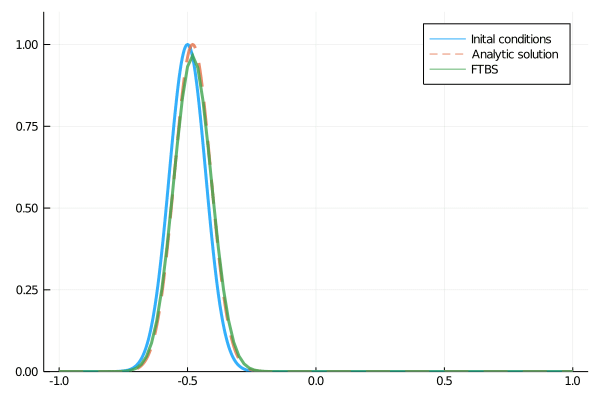

In [18]:
# Set inital conditions, true for contiunous, false for discontiunous
cts = true

n = 101
L = 1
U = 1
distance = 1
CFL = 0.1
σ² = 0.005
dx, dt, x, x0, c, c0, ftbs, time_steps = set_initial_conditions_advection(n, L, U, distance, CFL, cts, σ²) 

anim = @animate for i in 1:time_steps/10
    if cts
        analytic = c_analytic(x0, dt*10*i*U, σ²)
    else
        analytic = c_analytic(x0, dt*10*i*U)
    end
    plot(x0, [c0, analytic], ylims=(0, 1.1), label = ["Inital conditions" "Analytic solution"], 
        linestyle=[:solid :dash], lw=3, alpha=0.8)
    for j in 1:10
        next_step_matrix!(c, ftbs)
    end
    plot!(x, [c], ylims=(0, 1.1), label = "FTBS", linestyle=:solid , lw=3, alpha=0.8)
end

gif(anim, "advection_ftbs.gif", fps=300)

Modelling the advection equation with the CTCS scheme, note the numerical dispersion

┌ Info: Saved animation to 
│   fn = C:\Users\User\OneDrive - Australian National University\Documents\2020\ASC\Edited\advection_ctcs.gif
└ @ Plots C:\Users\User\.julia\packages\Plots\XbAWb\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\User\\OneDrive - Australian National University\\Documents\\2020\\ASC\\Edited\\advection_ctcs.gif")
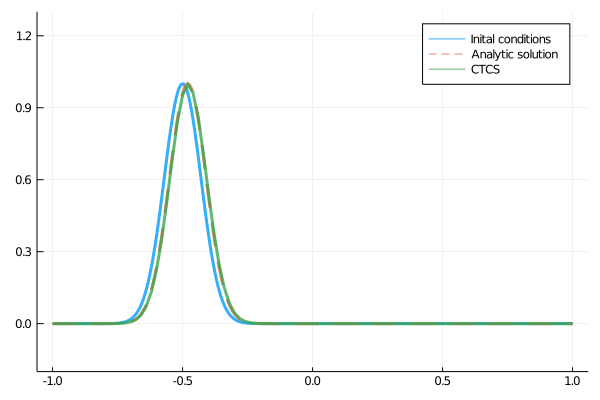

In [19]:
# Set inital conditions, true for contiunous, false for discontiunous
cts = true

n = 101
L = 1
U = 1
distance = 1
CFL = 0.1
σ² = 0.005
dx, dt, x, x0, c, c0, ftbs, time_steps = set_initial_conditions_advection(n, L, U, distance, CFL, cts, σ²) 
cprevious = zeros(n)
cprevious .= c
ctemp = zeros(n)
next_step_matrix!(c, ftbs)

anim = @animate for i in 1:time_steps/10
    if cts
        analytic = c_analytic(x0, dt*10*i*U, σ²)
    else
        analytic = c_analytic(x0, dt*10*i*U)
    end
    plot(x0, [c0, analytic], ylims=(0, 1.1), label = ["Inital conditions" "Analytic solution"], 
        linestyle=[:solid :dash], lw=3, alpha=0.8)
    for j in 1:10
        next_step_ctcs!(c, cprevious, ctemp, U*dt/dx)
    end
    plot!(x, c, ylims=(-0.2, 1.3), label = "CTCS", linestyle= :solid, lw=3, alpha=0.8)
end

gif(anim, "advection_ctcs.gif", fps=300)

Modelling the advection equation with WENO schemes, note the sharp, stable discontiunity transitions

┌ Info: Saved animation to 
│   fn = C:\Users\User\OneDrive - Australian National University\Documents\2020\ASC\Edited\advection_ctcs.gif
└ @ Plots C:\Users\User\.julia\packages\Plots\XbAWb\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\User\\OneDrive - Australian National University\\Documents\\2020\\ASC\\Edited\\advection_ctcs.gif")
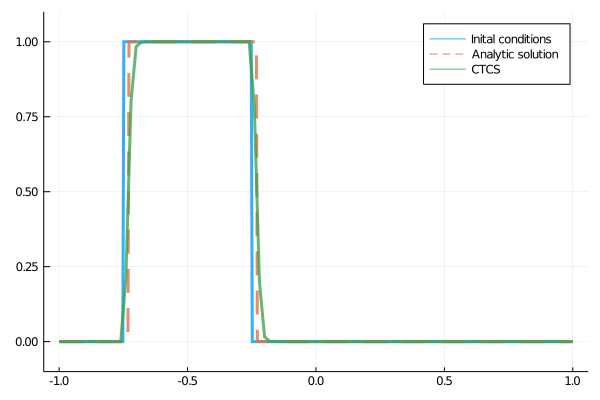

In [20]:
# Set inital conditions, true for contiunous, false for discontiunous
cts = false

n = 101
L = 1
U = 1
distance = 1
CFL = 0.1
σ² = 0.005
dx, dt, x, x0, c, c0, ftbs, time_steps = set_initial_conditions_advection(n, L, U, distance, CFL, cts, σ²) 
u = zeros(n)
cprimeᴿ = zeros(n)
cprimeᴸ = zeros(n)
cprime = zeros(n)
vel = U * ones(n)
anim = @animate for i in 1:time_steps/10
    if cts
        analytic = c_analytic(x0, dt*10*i*U, σ²)
    else
        analytic = c_analytic(x0, dt*10*i*U)
    end
    plot(x0, [c0, analytic], ylims=(0, 1.1), label = ["Inital conditions" "Analytic solution"], 
        linestyle=[:solid :dash], lw=3, alpha=0.8)
    for j in 1:10
        next_step_weno!(c, n, dx, dt, U, u, vel, cprimeᴸ, cprimeᴿ, cprime)
    end
    plot!(x, [c], ylims=(-0.1, 1.1), label = "CTCS", linestyle=:solid, lw=3, alpha=0.8)
end

gif(anim, "advection_ctcs.gif", fps=300)